In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV, StratifiedKFold, cross_val_predict, train_test_split
from sklearn.metrics import (confusion_matrix, classification_report, 
                           roc_auc_score, roc_curve, auc)
from sklearn.preprocessing import label_binarize
from itertools import cycle


In [2]:
df_tfidf = pd.read_pickle('tfi.pkl')

X = df_tfidf.drop(['num_label'], axis=1).values
y = df_tfidf['num_label'].values
classes = np.unique(y)

# Binarize the labels for ROC-AUC
y_bin = label_binarize(y, classes=[0, 1, 2, 3, 4])
n_classes = y_bin.shape[1]

# Define the parameter grid for grid search
param_grid = {
    'n_neighbors': [5, 7, 9, 11],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'cosine', 'manhattan'],
    'p': [1, 2]  # For minkowski metric
}

# Create KNN classifier
knn = KNeighborsClassifier()

# Set up 10-fold cross-validated grid search
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
grid_search = GridSearchCV(estimator=knn, param_grid=param_grid, 
                         cv=cv, scoring='accuracy', n_jobs=-1, verbose=1)

# Perform grid search
print("Performing grid search for KNN...")
grid_search.fit(X, y)

# Print best parameters and score
print("\nBest parameters found:")
print(grid_search.best_params_)
print(f"\nBest cross-validation accuracy: {grid_search.best_score_:.4f}")

# Get the best estimator
best_knn = grid_search.best_estimator_


Performing grid search for KNN...
Fitting 10 folds for each of 48 candidates, totalling 480 fits

Best parameters found:
{'metric': 'cosine', 'n_neighbors': 11, 'p': 1, 'weights': 'uniform'}

Best cross-validation accuracy: 0.8760



Classification report with best estimator (10-fold CV):
              precision    recall  f1-score   support

           0       0.87      0.96      0.91       200
           1       0.91      0.72      0.80       200
           2       0.79      0.97      0.87       200
           3       0.94      0.75      0.84       200
           4       0.90      0.97      0.94       200

    accuracy                           0.88      1000
   macro avg       0.88      0.88      0.87      1000
weighted avg       0.88      0.88      0.87      1000



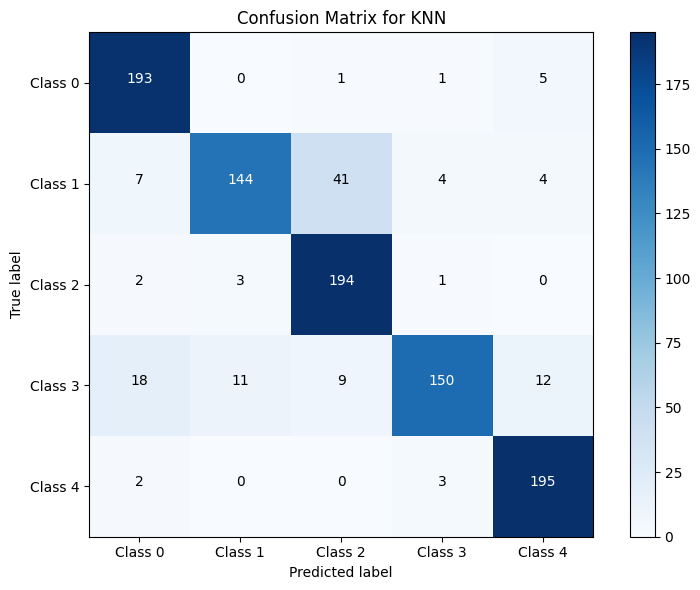

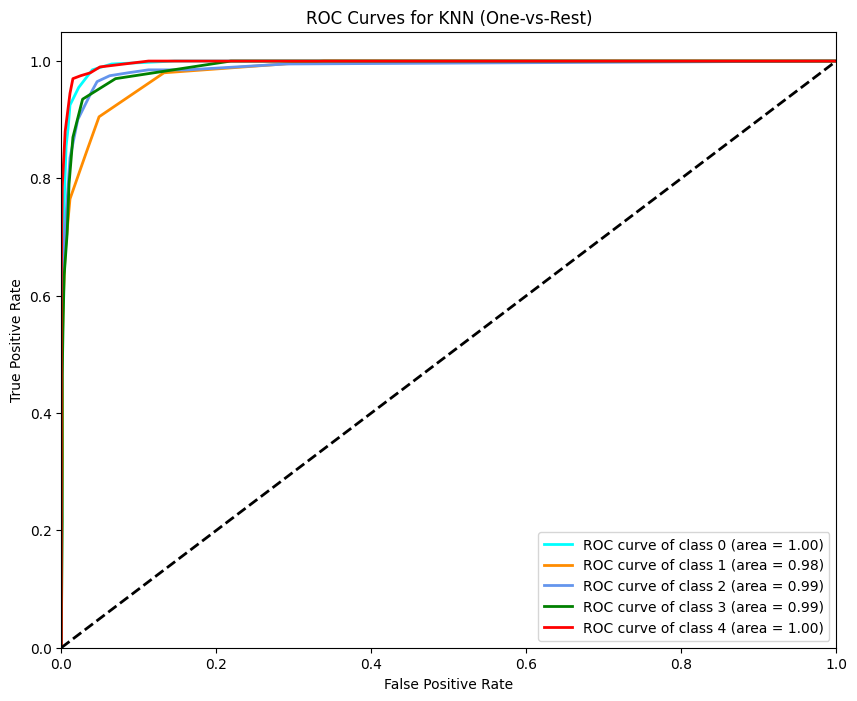


Average ROC-AUC score (One-vs-Rest): 0.9830 (±0.0066)


In [3]:

# Evaluate on the full dataset with cross-validation
print("\nClassification report with best estimator (10-fold CV):")
y_pred = cross_val_predict(best_knn, X, y, cv=cv)
print(classification_report(y, y_pred))

# Confusion matrix
cm = confusion_matrix(y, y_pred)
plt.figure(figsize=(8, 6))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title("Confusion Matrix for KNN")
plt.colorbar()
tick_marks = np.arange(5)
plt.xticks(tick_marks, [f"Class {i}" for i in range(5)])
plt.yticks(tick_marks, [f"Class {i}" for i in range(5)])

# Add text annotations
thresh = cm.max() / 2.
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, format(cm[i, j], 'd'),
                horizontalalignment="center",
                color="white" if cm[i, j] > thresh else "black")

plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.tight_layout()
plt.show()

# ROC-AUC curves
plt.figure(figsize=(10, 8))

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_bin[:, i], best_knn.predict_proba(X)[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_bin.ravel(), best_knn.predict_proba(X).ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at these points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'green', 'red'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
            label='ROC curve of class {0} (area = {1:0.2f})'
            ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for KNN (One-vs-Rest)')
plt.legend(loc="lower right")
plt.show()

# Print average ROC-AUC score
roc_auc_scores = []
for train, test in cv.split(X, y):
    best_knn.fit(X[train], y[train])
    y_score = best_knn.predict_proba(X[test])
    roc_auc_scores.append(roc_auc_score(y_bin[test], y_score, multi_class='ovr'))

print(f"\nAverage ROC-AUC score (One-vs-Rest): {np.mean(roc_auc_scores):.4f} (±{np.std(roc_auc_scores):.4f})")

In [8]:
# Split the data into 80% train and 20% test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, 
                                                    random_state=42, stratify=y)

y_test_bin = label_binarize(y_test, classes=[0, 1, 2, 3, 4])

params = {'metric': 'cosine', 'n_neighbors': 11, 'p': 1, 'weights': 'uniform'}

fin_knn = KNeighborsClassifier(**params)
fin_knn.fit(X_train, y_train)

# Evaluate on test set
y_pred = fin_knn.predict(X_test)
y_prob = fin_knn.predict_proba(X_test)  # for probability estimates

# Classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

roc_auc = roc_auc_score(y_test_bin, y_prob, multi_class='ovr')
print(f"\nROC-AUC Score (One-vs-Rest): {roc_auc:.4f}")

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
print("\nConfusion Matrix:")
print(cm)


Classification Report:
              precision    recall  f1-score   support

           0       0.82      1.00      0.90        40
           1       0.94      0.72      0.82        40
           2       0.87      0.97      0.92        40
           3       0.97      0.75      0.85        40
           4       0.89      0.97      0.93        40

    accuracy                           0.89       200
   macro avg       0.89      0.89      0.88       200
weighted avg       0.89      0.89      0.88       200


ROC-AUC Score (One-vs-Rest): 0.9773

Confusion Matrix:
[[40  0  0  0  0]
 [ 3 29  6  1  1]
 [ 0  1 39  0  0]
 [ 5  1  0 30  4]
 [ 1  0  0  0 39]]


In [10]:
import shap
# SHAP Explainability
print("\nComputing SHAP explanations...")

# Create a SHAP explainer
explainer = shap.Explainer(fin_knn.predict_proba, shap.sample(X, 10))  # Use subset for efficiency

# Compute SHAP values for a sample of instances
sample_idx = np.random.choice(X.shape[0], size=50, replace=False)
shap_values = explainer.shap_values(X[sample_idx])

# Plot summary of feature importance
shap.summary_plot(shap_values, X[sample_idx], class_names=[f"Class {i}" for i in range(5)])

# Plot force plot for a specific instance
instance_idx = 0  # Change this to see different examples
shap.force_plot(explainer.expected_value[0], shap_values[0][instance_idx], X[sample_idx][instance_idx],
                feature_names=[f"Feature {i}" for i in range(X.shape[1])], 
                class_names=[f"Class {i}" for i in range(5)])

# Plot decision plot for multiple instances
shap.decision_plot(explainer.expected_value[0], shap_values[0][:5], X[sample_idx][:5],
                  feature_names=[f"Feature {i}" for i in range(X.shape[1])])


Computing SHAP explanations...


KeyboardInterrupt: 

/tmp/ipykernel_15967/3478761762.py:29: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values, X_reduced[sample_indices])


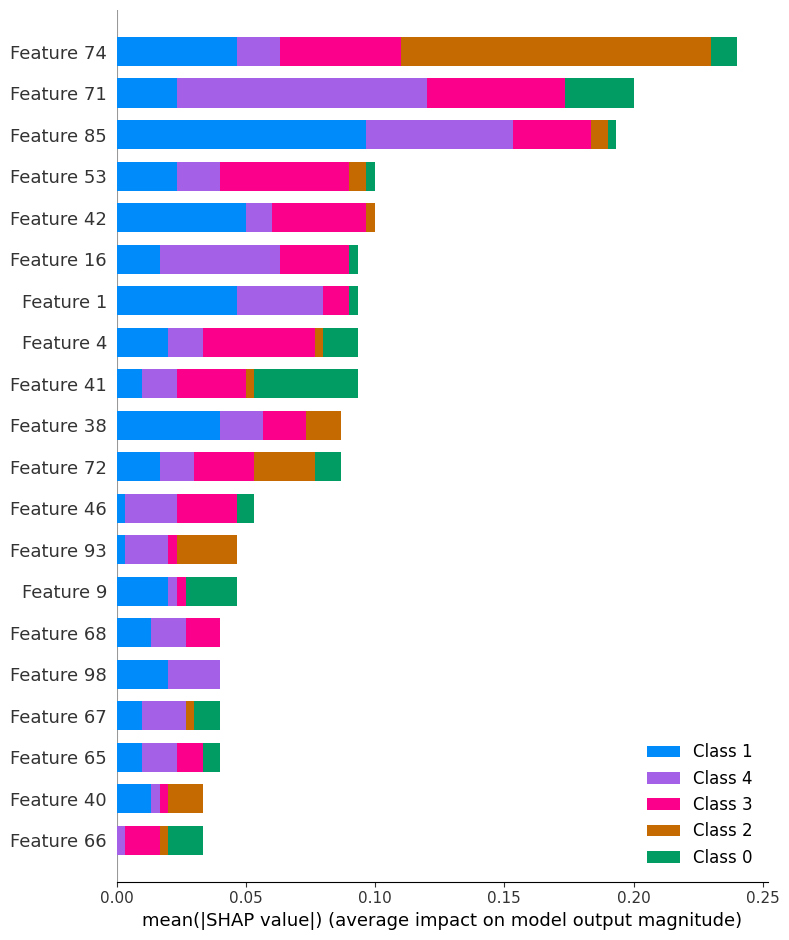

In [13]:
import numpy as np
import shap
from sklearn.neighbors import KNeighborsClassifier
from sklearn.feature_selection import SelectKBest, chi2

# 1. Feature Selection (reduce dimensionality)
selector = SelectKBest(chi2, k=100)  # Keep top 100 features
X_reduced = selector.fit_transform(X, y)

# 2. Train KNN on reduced features
knn = KNeighborsClassifier(n_neighbors=5, metric='cosine')
knn.fit(X_reduced, y)

# 3. Create efficient background dataset
background = shap.utils.sample(X_reduced, 10)  # 10 representative samples

# 4. Initialize explainer with adjusted parameters
explainer = shap.PermutationExplainer(
    knn.predict_proba,
    background,
    max_evals=2*X_reduced.shape[1]+2  # Meets minimum requirement
)

# 5. Explain a small sample
sample_indices = np.random.choice(X_reduced.shape[0], 3, replace=False)
shap_values = explainer(X_reduced[sample_indices])

# Visualize
shap.summary_plot(shap_values, X_reduced[sample_indices])

In [14]:
# 1. Partition features into groups
n_groups = 20
feature_groups = np.array_split(np.arange(X.shape[1]), n_groups)

# 2. Initialize explainer with grouped features
explainer = shap.KernelExplainer(
    knn.predict_proba,
    shap.sample(X, 10),  # Background sample
    feature_perturbation="interventional",
    feature_groups=feature_groups
)

# 3. Compute SHAP values with limited evaluations
shap_values = explainer.shap_values(
    X[:3],  # Only explain first 3 instances
    nsamples=200  # Compromise between accuracy and speed
)

# Visualize group importance
shap.summary_plot(shap_values, X[:3])

Provided model function fails when applied to the provided data set.


ValueError: X has 11694 features, but KNeighborsClassifier is expecting 100 features as input.